# Hydrogen Atom - Wavefunction and Electron Density Visualization 

*Modeling and visualization of hydrogen atom wavefunctions and electron probability density.*
* Author: Hrishit Das | 5th November 2023\
[Source](https://github.com/ssebastianmag/hydrogen-wavefunctions/blob/main/hydrogen_wavefunction_notebook.ipynb)

## Requirements | Import dependencies

In [1]:
from scipy.constants import physical_constants
import matplotlib, matplotlib.pyplot as plt
import scipy, scipy.special as sp
import seaborn as sns
import numpy as np

In [2]:
print('Matplotlib', matplotlib.__version__)
print('SciPy', scipy.__version__)
print('Seaborn', sns.__version__)
print('NumPy', np.__version__)

Matplotlib 3.7.0
SciPy 1.10.0
Seaborn 0.12.2
NumPy 1.23.5


### Normalized the Radial Wave Function 

The radial function describes the behavior of the electron as a function of distance $r$ from the nucleus, providing a means to visualize the density of electron clouds at different distances from the nucleus.\
$$R_{n \ell}(r) = \sqrt{\left( \frac{2}{n a_0} \right)^3 \frac{(n-\ell-1)!}{2n(n+\ell)!}} e^{-\frac{r}{n a_0}} \left( \frac{2r}{n a_0} \right)^{\ell} L_{n-\ell-1}^{2\ell+1}\left(\frac{2r}{n a_0}\right)$$

_______________________________________________________________________

**Process**:\
Compute the normalized radial part of the wavefunction using Laguerre polynomials and an exponential decay factor.
     
     Args:
         n (int): principal quantum number
         l (int): azimuthal quantum number
         r (numpy.ndarray): radial coordinate
         a0 (float): scaled Bohr radius
    Returns:
         numpy.ndarray: wavefunction radial component

In [3]:
def radial_function(n, l, r, a0):
    laguerre = sp.genlaguerre(n - l - 1, 2 * l + 1)
    p = 2 * r / (n * a0)

    constant_factor = np.sqrt(
        ((2 / n * a0) ** 3 * (sp.factorial(n - l - 1))) /
        (2 * n * (sp.factorial(n + l)))
    )
    return constant_factor * np.exp(-p / 2) * (p ** l) * laguerre(p)

### Normalized Angular Wave Function 

The angular function is described by spherical harmonics and is a function of the polar angle $\theta$ and the azimuthal angle $\varphi$. The angular function gives the shape and orientation of the atomic orbitals.

$$Y_{\ell}^{m}(\theta, \varphi) = (-1)^m \sqrt{\frac{(2\ell+1)}{4\pi}\frac{(\ell-m)!}{(\ell+m)!}} P_{\ell}^{m}(\cos\theta) e^{im\varphi}$$

________________________________________________________________________

Compute the normalized angular part of the wavefunction using Legendre polynomials and a phase-shifting exponential factor.

    Args:
        m (int): magnetic quantum number
        l (int): azimuthal quantum number
        theta (numpy.ndarray): polar angle
        phi (int): azimuthal angle
    Returns:
        numpy.ndarray: wavefunction angular component

In [5]:
def angular_function(m, l, theta, phi):
    legendre = sp.lpmv(m, l, np.cos(theta))

    constant_factor = ((-1) ** m) * np.sqrt(
        ((2 * l + 1) * sp.factorial(l - np.abs(m))) /
        (4 * np.pi * sp.factorial(l + np.abs(m)))
    )
    return constant_factor * legendre * np.real(np.exp(1.j * m * phi))

### Normalized Wavefunction 

The total wavefunction for the hydrogen atom is the product of the radial and angular components.

$$\psi_{n \ell m}(r, \theta, \varphi) = R_{n \ell}(r) Y_{\ell}^{m}(\theta, \varphi)$$


________________________________________________________________________

Compute the normalized wavefunction as a product of its radial and angular components.

    Args:
        n (int): principal quantum number
        l (int): azimuthal quantum number
        m (int): magnetic quantum number
        a0_scale_factor (float): Bohr radius scale factor
    Returns:
        numpy.ndarray: wavefunction

In [6]:
def compute_wavefunction(n, l, m, a0_scale_factor):
    # Scale Bohr radius for effective visualization
    a0 = a0_scale_factor * physical_constants['Bohr radius'][0] * 1e+12

    # x-y grid to represent electron spatial distribution
    grid_extent = 480
    grid_resolution = 680
    x = y = np.linspace(-grid_extent, grid_extent, grid_resolution)
    x, y = np.meshgrid(x, y)

    # Use epsilon to avoid division by zero during angle calculations
    eps = np.finfo(float).eps

    # Ψnlm(r,θ,φ) = Rnl(r).Ylm(θ,φ)
    psi = radial_function(
        n, l, np.sqrt((x ** 2 + y ** 2)), a0
    ) * angular_function(
        m, l, np.arctan(x / (y + eps)), 0
    )
    return psi

### Probability Density | Electron Density 

Quantifies the probabilities of finding a particle, such as an electron, at a particular point in space.

$|\psi_{n \ell m}|^2$

_______________________________________________________________________
Compute the probability density of a given wavefunction.
    
    Args:
        psi (numpy.ndarray): wavefunction
    Returns:
        numpy.ndarray: wavefunction probability density

In [7]:
def compute_probability_density(psi):
     return np.abs(psi) ** 2

It's crucial that the entire wavefunction is normalized. This means that when integrating $|\psi_{n \ell m}|^2$ over all space, the result should be 1, signifying that the electron must be found somewhere in space.
________________________________________________________________________

## Wave Function Probability Density Visualization 

In [22]:
def plot_wf_probability_density(n, l, m, a0_scale_factor, dark_theme=False, colormap='inferno'):
    """ Plot the probability density of the hydrogen
    atom's wavefunction for a given quantum state (n,l,m).

    Args:
        n (int): principal quantum number, determines the energy level and size of the orbital
        l (int): azimuthal quantum number, defines the shape of the orbital
        m (int): magnetic quantum number, defines the orientation of the orbital
        a0_scale_factor (float): Bohr radius scale factor
        dark_theme (bool): If True, uses a dark background for the plot, defaults to False
        colormap (str): Seaborn plot colormap, defaults to 'rocket'
    """

    # Quantum numbers validation
    if not isinstance(n, int) or n < 1:
        raise ValueError('n should be an integer satisfying the condition: n >= 1')
    if not isinstance(l, int) or not (0 <= l < n):
        raise ValueError('l should be an integer satisfying the condition: 0 <= l < n')
    if not isinstance(m, int) or not (-l <= m <= l):
        raise ValueError('m should be an integer satisfying the condition: -l <= m <= l')

    # Colormap validation
    try:
        sns.color_palette(colormap)
    except ValueError:
        raise ValueError(f'{colormap} is not a recognized Seaborn colormap.')

    # Configure plot aesthetics using matplotlib rcParams settings
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['xtick.major.width'] = 4
    plt.rcParams['ytick.major.width'] = 4
    plt.rcParams['xtick.major.size'] = 15
    plt.rcParams['ytick.major.size'] = 15
    plt.rcParams['xtick.labelsize'] = 30
    plt.rcParams['ytick.labelsize'] = 30
    plt.rcParams['axes.linewidth'] = 4

    fig, ax = plt.subplots(figsize=(16, 16.5))
    plt.subplots_adjust(top=0.82)
    plt.subplots_adjust(right=0.905)
    plt.subplots_adjust(left=-0.1)

    # Compute and visualize the wavefunction probability density
    psi = compute_wavefunction(n, l, m, a0_scale_factor)
    prob_density = compute_probability_density(psi)
    im = ax.imshow(np.sqrt(prob_density), cmap=sns.color_palette(colormap, as_cmap=True))

    cbar = plt.colorbar(im, fraction=0.046, pad=0.03)
    cbar.set_ticks([])

    # Apply dark theme parameters
    if dark_theme:
        theme = 'dt'
        background_color = sorted(
            sns.color_palette(colormap, n_colors=100),
            key=lambda color: 0.2126 * color[0] + 0.7152 * color[1] + 0.0722 * color[2]
        )[0]
        plt.rcParams['text.color'] = '#dfdfdf'
        title_color = '#dfdfdf'
        fig.patch.set_facecolor(background_color)
        cbar.outline.set_visible(False)
        ax.tick_params(axis='x', colors='#c4c4c4')
        ax.tick_params(axis='y', colors='#c4c4c4')
        for spine in ax.spines.values():
            spine.set_color('#c4c4c4')

    else:  # Apply light theme parameters
        theme = 'lt'
        plt.rcParams['text.color'] = '#000000'
        title_color = '#000000'
        ax.tick_params(axis='x', colors='#000000')
        ax.tick_params(axis='y', colors='#000000')

    ax.set_title('Hydrogen Atom - Wavefunction Electron Density', pad=130, fontsize=44, loc='left', color=title_color)
    ax.text(0, 722, (
        r'$|\psi_{n \ell m}(r, \theta, \varphi)|^{2} ='
        r' |R_{n\ell}(r) Y_{\ell}^{m}(\theta, \varphi)|^2$'
    ), fontsize=36)
    ax.text(30, 615, r'$({0}, {1}, {2})$'.format(n, l, m), color='#dfdfdf', fontsize=42)
    ax.text(770, 140, 'Electron probability distribution', rotation='vertical', fontsize=40)
    ax.text(705, 700, 'Higher\nprobability', fontsize=24)
    ax.text(705, -60, 'Lower\nprobability', fontsize=24)
    ax.text(775, 590, '+', fontsize=34)
    ax.text(769, 82, '−', fontsize=34, rotation='vertical')
    ax.invert_yaxis()

    # Save and display the plot
    # plt.savefig(f'({n},{l},{m})[{theme}].png')
    plt.show()

* By taking the square root of the probability density we reduce the dynamic range of the visualization, spreading out the values and making the electron's presence in low and medium probability regions more distinguishable.
____________________________________________________________

### Example probability densities for various quantum states  $({n, l, m})$

Light shaded areas in the orbital cross-sections represent a high probability of a particle being present in that region. Conversely, darker or unshaded regions indicate areas where the electron is less likely to be found.

In [23]:
plt.rcParams['figure.dpi'] = 38

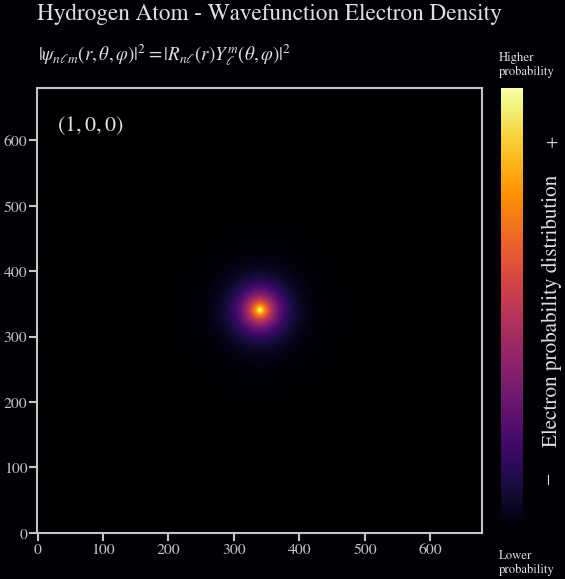

In [34]:
plot_wf_probability_density(1,0,0, 0.6, True)

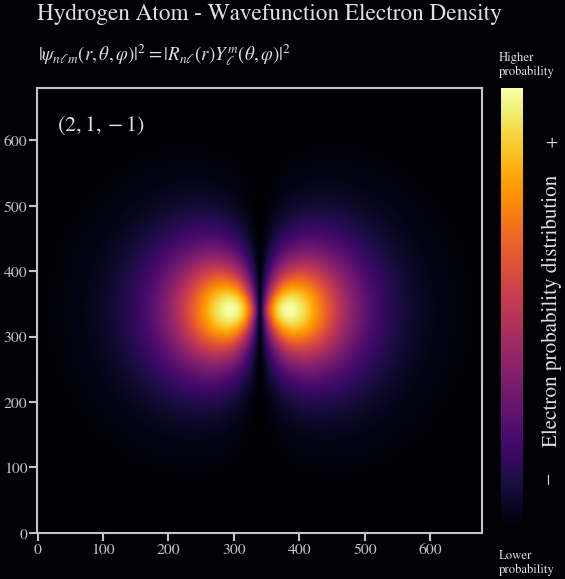

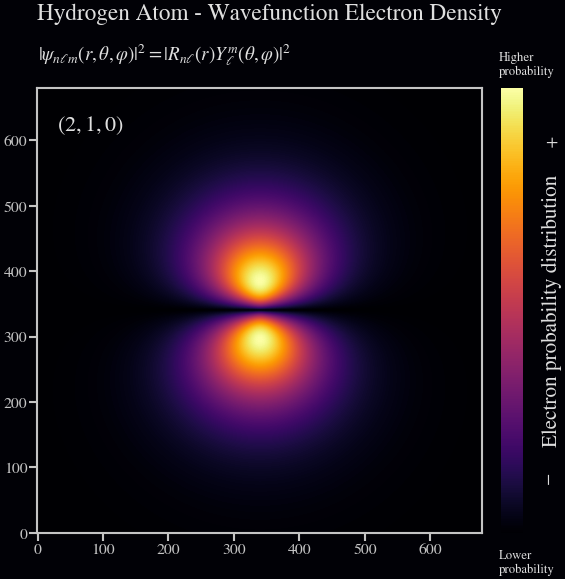

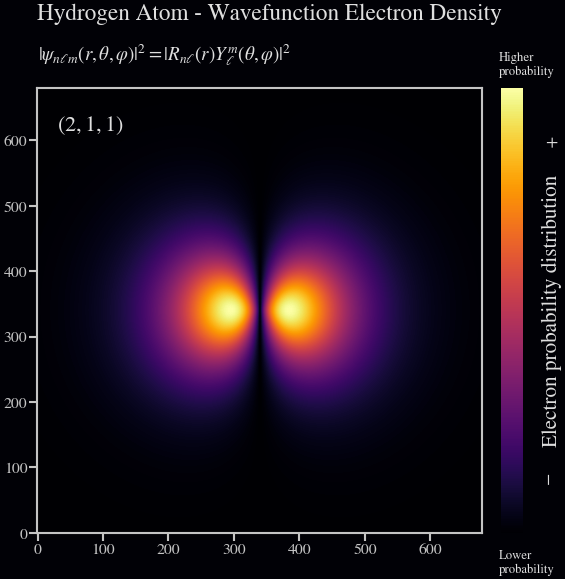

In [37]:
plot_wf_probability_density(2,1,-1, 0.6, True) 
plot_wf_probability_density(2,1,0, 0.6, True)
plot_wf_probability_density(2,1,1, 0.6, True)

As we examine the electron density plots corresponding to the quantum numbers above, we notice that with increasing principal quantum number $n$, the complexity of the wavefunction grows Specifically:
* The number of nodes (regions where the probability density is zero) increases.
* The electron's spatial distribution expands, covering larger regions around the nucleus.
* The overall shape of the atomic orbital becomes more intricate and detailed.

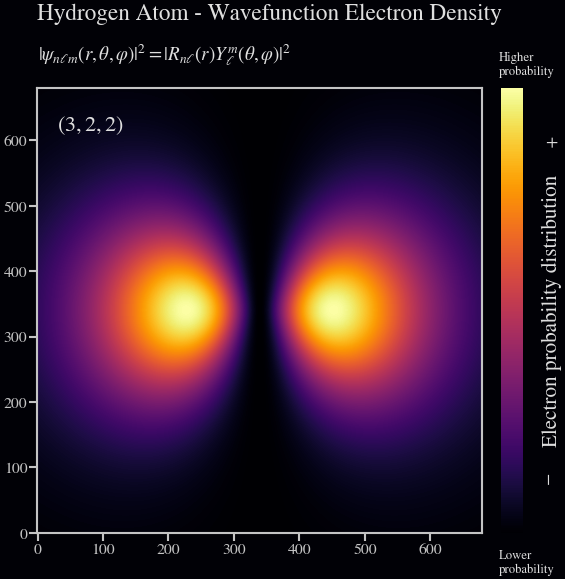

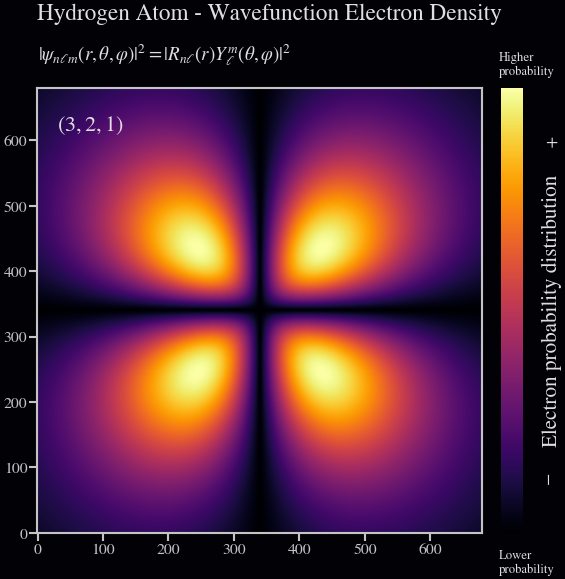

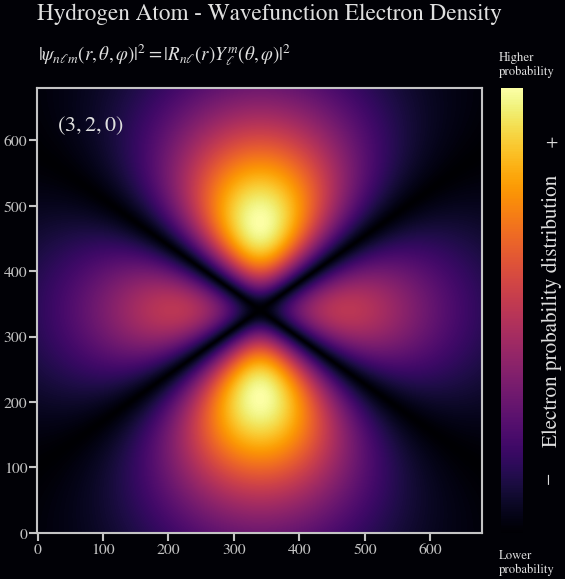

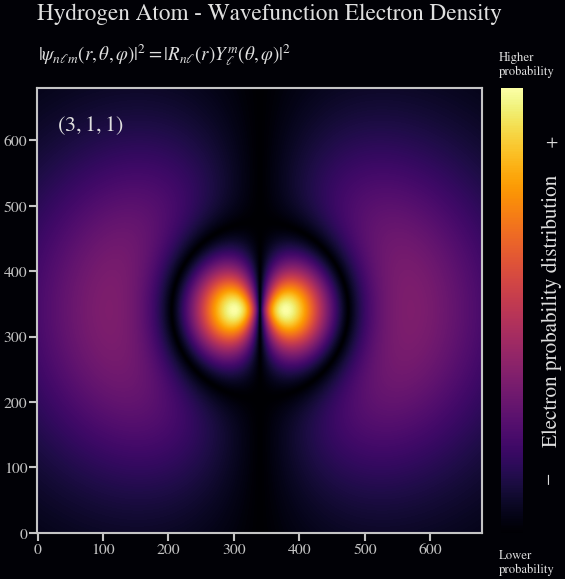

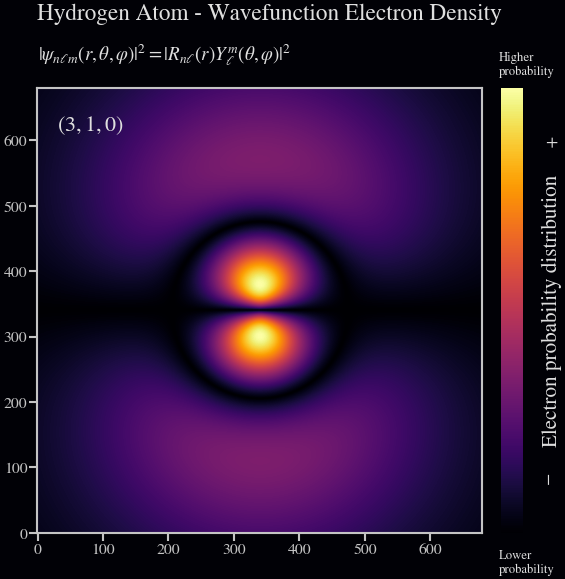

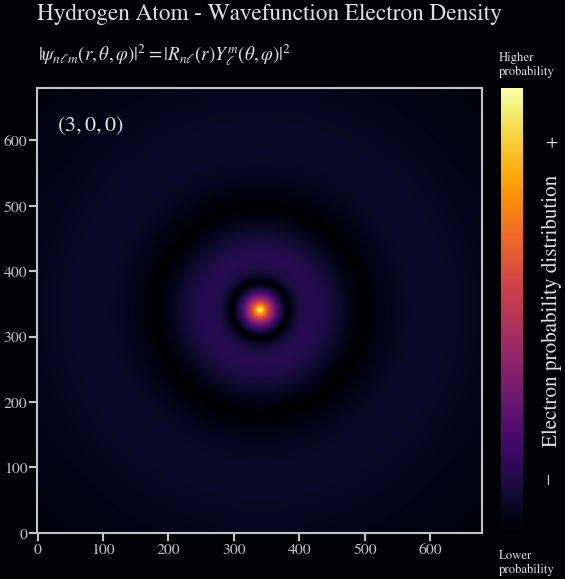

In [64]:
plot_wf_probability_density(3,2,2, 0.5, True)
plot_wf_probability_density(3,2,1, 0.6, True)
plot_wf_probability_density(3,2,0, 0.6, True)
plot_wf_probability_density(3,1,1, 0.6, True)
plot_wf_probability_density(3,1,0, 0.6, True)
plot_wf_probability_density(3,0,0, 0.6, True)

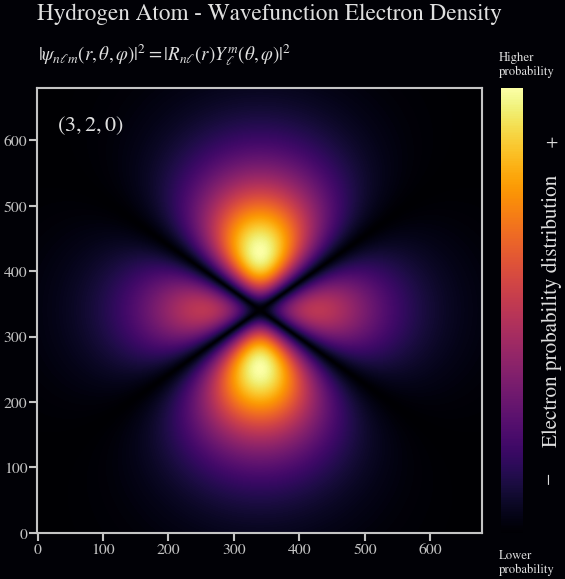

In [67]:
plot_wf_probability_density(3,2,0, 0.4, True)

For extremely high quantum numbers, the following effects can be observed:
* The complexity increases even further, resulting in numerous nodes and intricate patterns.
* Evaluating the wavefunction over a vast spatial domain becomes computationally intensive.
* Visualization can become cluttered, making it harder to discern specific details or features.